## Общие функции

In [ ]:
from keras.datasets import mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [ ]:
# constants 
num_epochs = 2
batch_size = 50
mnist_model_name = 'mnist_model.ckpt'
MODEL_STORE_PATH = "./"
continuation_fashion_mnist_model_name = 'continuation_fashion_mnist_model.ckpt'
fashion_mnist_model_name = 'fashion_mnist_model.ckpt'
freeze_fashion_mnist_model_name = 'freeze_fashion_mnist_model.ckpt'
unfreeze_fashion_mnist_model_name = 'unfreeze_fashion_mnist_model.ckpt'

In [ ]:
# imports 
import tensorflow as tf
import torch.nn as nn
from tensorflow.keras import datasets, layers, models
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
def do_train_and_test_by_loader(model, train_loader, test_loader, criterion=nn.CrossEntropyLoss(), num_epochs=num_epochs):  
  start_time = time.time()
  learning_rate = 0.001
  criterion = nn.CrossEntropyLoss() # объединяет и SoftMax и кросс-энтропийную функцию потерь в единую функцию
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

  total_step = len(train_loader)
  train_loss = []
  train_acc = []
  test_acc = []
  risks = []
  iter = 0

  check_point = 10_000 // batch_size

  risk = 0.0

  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
        iter += 1
        # Прямой запуск
        outputs = model(images)
        loss = criterion(outputs, labels)
        risk += loss.item()

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        
        if iter % check_point == 0:
          risks.append(risk / check_point)
          risk = 0.0
          train_loss.append(loss.item())
          train_acc.append(correct / total)
          with torch.no_grad():
            test_correct = 0
            test_total = 0
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

            test_acc.append(test_correct / test_total)

          print('Epoch [{}/{}], Step [{}/{}] '
                  .format(epoch + 1, num_epochs, i + 1, total_step))
          print('   Train: Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(loss.item(), (correct / total) * 100))
          print('   Test: Accuracy: {:.2f}%'
                .format((test_correct / test_total) * 100))
  print('Execution time: {} seconds'.format(time.time() - start_time))
  return train_acc, test_acc, risks

In [ ]:
def plot_acc_and_risks(train_acc, test_acc, risks, file_name):
  # Сохраняем модель и строим график
  torch.save(model.state_dict(), MODEL_STORE_PATH + file_name)

  plt.rcParams["figure.figsize"] = (4,4)  
  plt.plot(np.arange(len(train_acc)), train_acc)
  plt.plot(np.arange(len(test_acc)), test_acc, "g-")
  plt.plot(np.arange(len(risks)), risks, "r-")
  plt.title('model accuracy and risks')
  plt.ylabel('accuracy')

  plt.xlabel('epoch')
  plt.legend(['train', 'test', 'risk'], loc='upper left')
  plt.show()

## MNIST

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(7 * 7 * 64, 1000) 
        self.fc2 = nn.Linear(1000, 10)

    def _block(self, dim_in: int, dim_out: int, kernel_size: int = 5, padding: int = 2) -> nn.Module:
        return nn.Sequential(
           nn.Conv2d(dim_in, dim_out, kernel_size, padding=padding), 
           nn.ReLU(),
           nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out
    
model = MnistModel()
# model

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data', 
        train=True, 
        download=True, 
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        ),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data', 
        train=False, 
        download=True, 
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        ),
    batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 101006798.24it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30329417.58it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26919824.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3417135.21it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_acc, test_acc, risks = do_train_and_test_by_loader(model, train_loader, test_loader)

Epoch [1/5], Step [200/1200] 
   Train: Loss: 2.0230, Accuracy: 50.00%
   Test: Accuracy: 58.33%
Epoch [1/5], Step [400/1200] 
   Train: Loss: 1.0073, Accuracy: 78.00%
   Test: Accuracy: 75.11%
Epoch [1/5], Step [600/1200] 
   Train: Loss: 0.6947, Accuracy: 80.00%
   Test: Accuracy: 81.82%
Epoch [1/5], Step [800/1200] 
   Train: Loss: 0.3646, Accuracy: 88.00%
   Test: Accuracy: 85.21%
Epoch [1/5], Step [1000/1200] 
   Train: Loss: 0.4137, Accuracy: 88.00%
   Test: Accuracy: 87.22%
Epoch [1/5], Step [1200/1200] 
   Train: Loss: 0.4151, Accuracy: 86.00%
   Test: Accuracy: 88.68%
Epoch [2/5], Step [200/1200] 
   Train: Loss: 0.5329, Accuracy: 80.00%
   Test: Accuracy: 89.51%
Epoch [2/5], Step [400/1200] 
   Train: Loss: 0.3067, Accuracy: 90.00%
   Test: Accuracy: 90.55%
Epoch [2/5], Step [600/1200] 
   Train: Loss: 0.2454, Accuracy: 92.00%
   Test: Accuracy: 91.01%
Epoch [2/5], Step [800/1200] 
   Train: Loss: 0.3343, Accuracy: 90.00%
   Test: Accuracy: 91.19%
Epoch [2/5], Step [1000/1200

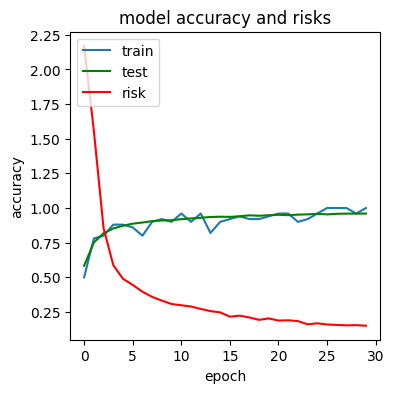

In [ ]:
plot_acc_and_risks(train_acc, test_acc, risks, mnist_model_name)

## Fashion Mnist 

In [ ]:
fashion_model = MnistModel()

batch_size = 50
fashion_train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
fashion_test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

train_acc, test_acc, risks = do_train_and_test_by_loader(fashion_model, fashion_train_loader, fashion_test_loader)

Epoch [1/2], Step [200/1200] 
   Train: Loss: 2.1923, Accuracy: 30.00%
   Test: Accuracy: 28.57%
Epoch [1/2], Step [400/1200] 
   Train: Loss: 1.8415, Accuracy: 54.00%
   Test: Accuracy: 49.04%
Epoch [1/2], Step [600/1200] 
   Train: Loss: 1.2537, Accuracy: 62.00%
   Test: Accuracy: 57.73%
Epoch [1/2], Step [800/1200] 
   Train: Loss: 0.9033, Accuracy: 70.00%
   Test: Accuracy: 60.31%
Epoch [1/2], Step [1000/1200] 
   Train: Loss: 1.3050, Accuracy: 48.00%
   Test: Accuracy: 61.77%
Epoch [1/2], Step [1200/1200] 
   Train: Loss: 1.0246, Accuracy: 66.00%
   Test: Accuracy: 64.07%
Epoch [2/2], Step [200/1200] 
   Train: Loss: 0.9545, Accuracy: 62.00%
   Test: Accuracy: 66.15%
Epoch [2/2], Step [400/1200] 
   Train: Loss: 0.8797, Accuracy: 66.00%
   Test: Accuracy: 67.61%
Epoch [2/2], Step [600/1200] 
   Train: Loss: 0.8688, Accuracy: 60.00%
   Test: Accuracy: 69.02%
Epoch [2/2], Step [800/1200] 
   Train: Loss: 0.9513, Accuracy: 66.00%
   Test: Accuracy: 70.77%
Epoch [2/2], Step [1000/1200

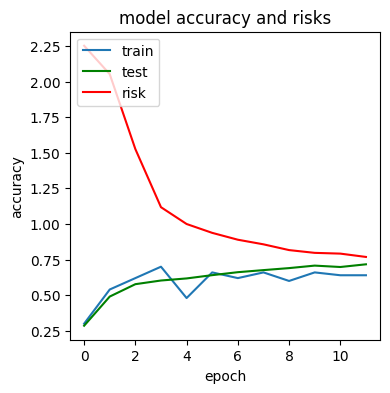

In [23]:
plot_acc_and_risks(train_acc, test_acc, risks, fashion_mnist_model_name)

## Fashion Mnist with saved Mnist parameters

In [24]:
continuation_model = MnistModel()
continuation_model.load_state_dict(torch.load(MODEL_STORE_PATH + mnist_model_name))


train_acc, test_acc, risks = do_train_and_test_by_loader(continuation_model, fashion_train_loader, fashion_test_loader)

Epoch [1/2], Step [200/1200] 
   Train: Loss: 1.3273, Accuracy: 52.00%
   Test: Accuracy: 54.40%
Epoch [1/2], Step [400/1200] 
   Train: Loss: 1.0031, Accuracy: 72.00%
   Test: Accuracy: 63.74%
Epoch [1/2], Step [600/1200] 
   Train: Loss: 0.9893, Accuracy: 58.00%
   Test: Accuracy: 67.10%
Epoch [1/2], Step [800/1200] 
   Train: Loss: 0.8905, Accuracy: 64.00%
   Test: Accuracy: 69.69%
Epoch [1/2], Step [1000/1200] 
   Train: Loss: 0.5838, Accuracy: 80.00%
   Test: Accuracy: 71.05%
Epoch [1/2], Step [1200/1200] 
   Train: Loss: 0.6836, Accuracy: 72.00%
   Test: Accuracy: 73.26%
Epoch [2/2], Step [200/1200] 
   Train: Loss: 0.9946, Accuracy: 70.00%
   Test: Accuracy: 73.69%
Epoch [2/2], Step [400/1200] 
   Train: Loss: 0.7665, Accuracy: 74.00%
   Test: Accuracy: 74.70%
Epoch [2/2], Step [600/1200] 
   Train: Loss: 0.6782, Accuracy: 74.00%
   Test: Accuracy: 74.93%
Epoch [2/2], Step [800/1200] 
   Train: Loss: 0.7088, Accuracy: 76.00%
   Test: Accuracy: 75.41%
Epoch [2/2], Step [1000/1200

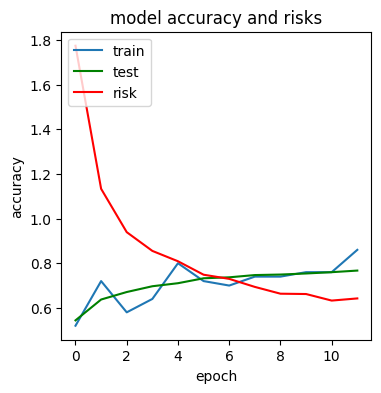

In [25]:
plot_acc_and_risks(train_acc, test_acc, risks, continuation_fashion_mnist_model_name)

По графикам кажется, что в данном эксперименте обучение модели проходило более плавно

## Fashion Mnist with freezed parameters

In [32]:
freeze_model = MnistModel()
freeze_model.load_state_dict(torch.load(MODEL_STORE_PATH + mnist_model_name))

<All keys matched successfully>

In [33]:
# freeze convolution layers
print('all params:')
for name, param in freeze_model.named_parameters():
  print(name)
print('\nfrozen:')
for name, param in freeze_model.named_parameters():
  if param.requires_grad and ('layer1.0' in name or 'layer2.0' in name):
      param.requires_grad = False
      print(name)

all params:
layer1.0.weight
layer1.0.bias
layer2.0.weight
layer2.0.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias

frozen:
layer1.0.weight
layer1.0.bias
layer2.0.weight
layer2.0.bias


In [34]:
train_acc, test_acc, risks = do_train_and_test_by_loader(freeze_model, fashion_train_loader, fashion_test_loader)

Epoch [1/2], Step [200/1200] 
   Train: Loss: 1.4890, Accuracy: 54.00%
   Test: Accuracy: 52.50%
Epoch [1/2], Step [400/1200] 
   Train: Loss: 1.0489, Accuracy: 68.00%
   Test: Accuracy: 61.26%
Epoch [1/2], Step [600/1200] 
   Train: Loss: 1.2248, Accuracy: 52.00%
   Test: Accuracy: 65.50%
Epoch [1/2], Step [800/1200] 
   Train: Loss: 0.8959, Accuracy: 62.00%
   Test: Accuracy: 67.67%
Epoch [1/2], Step [1000/1200] 
   Train: Loss: 0.9962, Accuracy: 64.00%
   Test: Accuracy: 69.59%
Epoch [1/2], Step [1200/1200] 
   Train: Loss: 0.9137, Accuracy: 74.00%
   Test: Accuracy: 70.95%
Epoch [2/2], Step [200/1200] 
   Train: Loss: 0.8183, Accuracy: 76.00%
   Test: Accuracy: 71.82%
Epoch [2/2], Step [400/1200] 
   Train: Loss: 0.7863, Accuracy: 74.00%
   Test: Accuracy: 72.84%
Epoch [2/2], Step [600/1200] 
   Train: Loss: 0.7907, Accuracy: 80.00%
   Test: Accuracy: 73.05%
Epoch [2/2], Step [800/1200] 
   Train: Loss: 0.6241, Accuracy: 80.00%
   Test: Accuracy: 73.47%
Epoch [2/2], Step [1000/1200

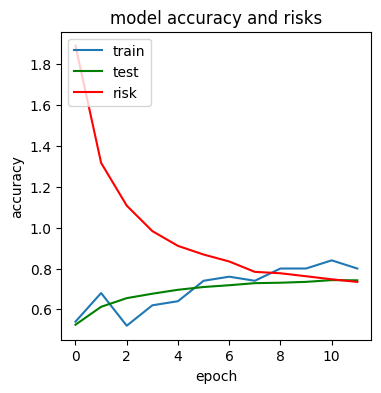

In [35]:
plot_acc_and_risks(train_acc, test_acc, risks, freeze_fashion_mnist_model_name)

## Fashion Mnist: unfreeze and retrain parameters 

In [36]:
freeze_model = MnistModel()
freeze_model.load_state_dict(torch.load(MODEL_STORE_PATH + mnist_model_name))

# freeze convolution layers
print('all params:')
for name, param in freeze_model.named_parameters():
  print(name)
print('\nfrozen:')
for name, param in freeze_model.named_parameters():
  if param.requires_grad and ('layer1.0' in name or 'layer2.0' in name):
      param.requires_grad = False
      print(name)

# do train 
train_acc1, test_acc1, risks1 = do_train_and_test_by_loader(freeze_model, fashion_train_loader, fashion_test_loader, num_epochs=2)

# unfreeze convolution layers
print('\nunfrozen:')
for name, param in freeze_model.named_parameters():
  if param.requires_grad and ('layer1.0' in name or 'layer2.0' in name):
      param.requires_grad = True
      print(name)

# do train
train_acc, test_acc, risks = do_train_and_test_by_loader(freeze_model, fashion_train_loader, fashion_test_loader, num_epochs=2)

all params:
layer1.0.weight
layer1.0.bias
layer2.0.weight
layer2.0.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias

frozen:
layer1.0.weight
layer1.0.bias
layer2.0.weight
layer2.0.bias
Epoch [1/2], Step [200/1200] 
   Train: Loss: 1.5055, Accuracy: 52.00%
   Test: Accuracy: 52.23%
Epoch [1/2], Step [400/1200] 
   Train: Loss: 1.2901, Accuracy: 60.00%
   Test: Accuracy: 61.75%
Epoch [1/2], Step [600/1200] 
   Train: Loss: 0.9800, Accuracy: 66.00%
   Test: Accuracy: 66.40%
Epoch [1/2], Step [800/1200] 
   Train: Loss: 1.0885, Accuracy: 66.00%
   Test: Accuracy: 68.03%
Epoch [1/2], Step [1000/1200] 
   Train: Loss: 0.9533, Accuracy: 60.00%
   Test: Accuracy: 69.76%
Epoch [1/2], Step [1200/1200] 
   Train: Loss: 0.9965, Accuracy: 60.00%
   Test: Accuracy: 71.47%
Epoch [2/2], Step [200/1200] 
   Train: Loss: 0.7558, Accuracy: 72.00%
   Test: Accuracy: 71.73%
Epoch [2/2], Step [400/1200] 
   Train: Loss: 0.8976, Accuracy: 70.00%
   Test: Accuracy: 73.08%
Epoch [2/2], Step [600/1200] 
   Train: L

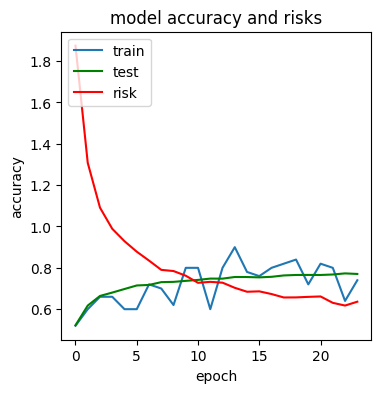

In [37]:
plot_acc_and_risks(train_acc1 + train_acc, test_acc1 + test_acc, risks1 + risks, unfreeze_fashion_mnist_model_name)